In [87]:
rta = zeros(Float64, 100, 50)

for i in 1:100
    d = quantile(dist, max(1 - op_cost / delay_cost / ridership[i], 1e-4))
    d = max(d, 0)
    for j in 1:50
        integral, error = quadgk(f, buffers[j], Inf)
        flag = d > buffers[j]
        v = (flag+1) * veh_cost
        o = max(buffers[j], d) / 60 * op_cost
        p = (!flag) * delay_cost * ridership[i] * integral / 60
        rta[i, j] = v + o + p
    end
end

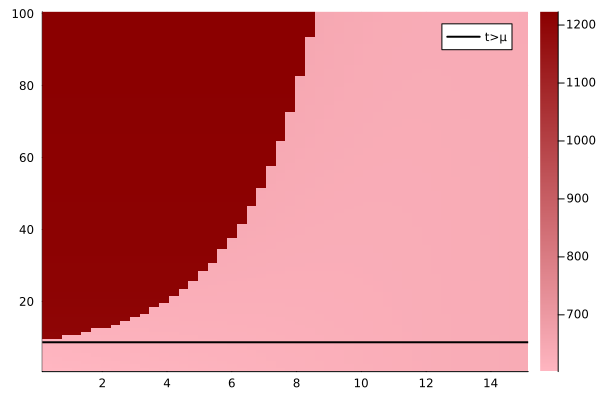

In [98]:
heatmap(
    buffers,
    ridership,
    rta,
    color=:reds,
)
hline!(
    [8.65],
    lw=2,
    color=:black,
    label="t>μ"
)

In [91]:
delay_aware = zeros(Float64, 100, 50)

for i in 1:50
    integral, error = quadgk(f, buffers[i], Inf)
    for j in 1:100
        flag = (veh_cost - delay_cost * ridership[j] * integral / 60) / op_cost < buffers[i] / 60
        v = (flag+1) * veh_cost
        o = (!flag) * buffers[i] * op_cost / 60
        p = (!flag) * delay_cost * ridership[j] * integral / 60
        delay_aware[j, i] = v + o + p
    end
end

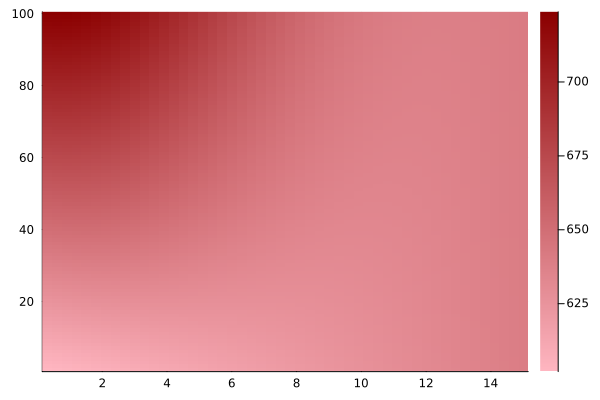

In [92]:
heatmap(
    buffers,
    ridership,
    delay_aware,
    color=:reds,
)

In [93]:
hmap = rta - delay_aware;

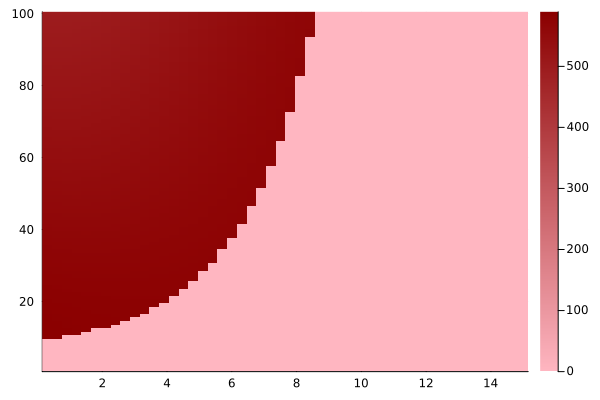

In [94]:
heatmap(
    buffers,
    ridership,
    hmap,
    color=:reds,
)

In [95]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/lagrange.jl")
include("./src/out.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


In [23]:
function distance(pt1, pt2)
    x = pt2[1] - pt1[1]
    y = pt2[2] - pt1[2]

    return sqrt(x^2 + y^2)
end;

In [27]:
function createTrips(X::Matrix{Float32})
    df = DataFrame(
        trip_id=Int[],
        route_id=Int[],
        start_time=Float32[],
        stop_time=Float32[],
        start_lat=Float32[],
        start_lon=Float32[],
        stop_lat=Float32[],
        stop_lon=Float32[],
    )

    for (i, row) in enumerate(eachrow(X))
        push!(df, vcat(i, row))
    end

    return df
end;

In [25]:
function VSPInstanceSimple(
	trips::DataFrame,
	r::Vector{Float64},
	L_train::Matrix{Float64},
	L_test::Matrix{Float64};
	op_cost = 160, # $ per hour of operation
	delay_cost = 37, # $ per passenger waiting hour
	veh_cost = 600, # $ per vehicle
	averageSpeed::Float64 = 30.0,
	depot_loc = (mean(trips[:, :start_lat]), mean(trips[:, :start_lon]))
)
    percentile = min.(max.(1 .- op_cost ./ delay_cost ./ r, 0), 1)
    q = quantile.(eachrow(L_train), percentile)
    q = max.(mean(L_train, dims=2), q)
    rta_trips = copy(trips)
    rta_trips.stop_time .+= q
    # add RTA trips
    trips = vcat(trips, rta_trips)
    L_train = vcat(L_train, L_train .- q)
    L_test = vcat(L_test, L_test .- q)
    r = vcat(r, r)
	L_train = vcat(zeros(Float64, 1, size(L_train, 2)), L_train)
	L_test = vcat(zeros(Float64, 1, size(L_test, 2)), L_test)

	n = size(trips, 1) + 1
	C = zeros(Float64, n, n)
    C[1, 2:end] .= veh_cost # cost per vehicle
	B = zeros(Float64, n, n)
	G = zeros(Bool, n, n)
	G[1, 2:end] .= 1 # add link from depot to each trip
	G[2:end, 1] .= 1 # add link from each trip to depot
	D = zeros(Float64, n, n) # deadhead time between start/stop points
	V = zeros(Bool, n, n)

	for i ∈ 1:n-1
		D[1, i+1] = distance(depot_loc, (trips[i, :start_lat], trips[i, :start_lon])) / averageSpeed 
		D[i+1, 1] = distance((trips[i, :stop_lat], trips[i, :stop_lon]), depot_loc) / averageSpeed 
		C[1, i+1] += D[1, i+1] * op_cost
		C[i+1, 1] = D[i+1, 1] * op_cost
		if i > n/2.0
			C[1, i+1] += q[i-size(q, 1)] * op_cost
		end
		for j ∈ 1:n-1
            i == j && continue
			timeDiff = trips[j, :start_time] - trips[i, :stop_time]
			timeDiff < 0 && continue
			coords_1 = (trips[i, :stop_lat], trips[i, :stop_lon])
			coords_2 = (trips[j, :start_lat], trips[j, :start_lon])
			dist = distance(coords_1, coords_2)
			D[i+1, j+1] = dist / averageSpeed
			if dist / averageSpeed <= timeDiff
				G[i+1, j+1] = 1 # add link if vehicle can deadhead from i -> j
                B[i+1, j+1] = timeDiff - dist / averageSpeed
				if timeDiff < 3.0
	                C[i+1, j+1] = (dist / averageSpeed + timeDiff) * op_cost # cost per hour
				else
					V[i+1, j+1] = 1
					d1 = distance(coords_1, depot_loc)
					d2 = distance(depot_loc, coords_2)
					D[i+1, j+1] = (d1+d2) / averageSpeed
					C[i+1, j+1] = ((d1 + d2) / averageSpeed) * op_cost * 2 # return to depot
				end
				if j > n/2.0
					C[i+1, j+1] += q[j-size(q, 1)] * op_cost
				end
			end
		end
	end

	# using longest path to tighten big-M
	g = SimpleDiGraph(G[2:end, 2:end])
	m = -1*minimum(Graphs.dijkstra_shortest_paths(g, findall(G[1,2:end]), -1*ones(Int, n-1, n-1)).dists)
	M = sum(sort(maximum.(eachrow(L_train)), rev=true)[1:m])
    B[2:end, 1] .= M # *infinite* buffer time when returning to depot

	return VSPInstance(n, M, op_cost, delay_cost, veh_cost, L_train, L_test, r, C, B, D, V, G, trips)
end;

In [28]:
trips = Float32[
        # route_id start_time stop_time start_lat start_lon stop_lat stop_lon
          1        0          1         0         0         0        1;
          1        1          2         0         1         0        0
]

trips = createTrips(trips)
first(trips, 5)

Row,trip_id,route_id,start_time,stop_time,start_lat,start_lon,stop_lat,stop_lon
,Int64,Int64,Float32,Float32,Float32,Float32,Float32,Float32
1,1,1,0.0,1.0,0.0,0.0,0.0,1.0
2,2,1,1.0,2.0,0.0,1.0,0.0,0.0


In [100]:
r = Float64[100, 10]
# L_train = Float64[
#     0.1 -0.1;
#     0.1 -0.1
# ]
L_train = Float64[
    1 1;
    0 0.1
]
L_test = L_train;

In [101]:
instance = VSPInstanceSimple(trips, r, L_train, L_test);

In [102]:
del_model = VSPModel(instance; endoftrip = true)
del_solution = solve!(del_model; silent = false);

numTrips = 4
numVehicles = 2.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 1387.7477477477476
solve_time(mod.model) = 0.002000093460083008


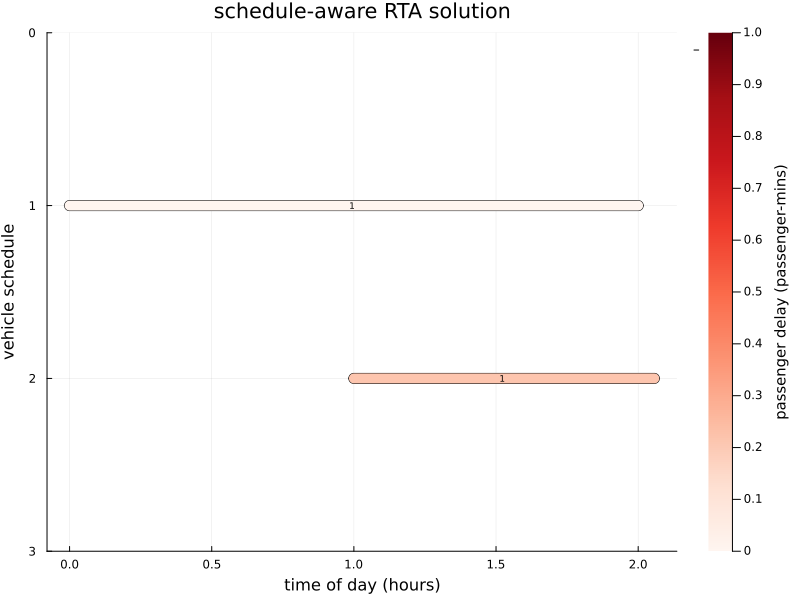

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [103]:
del_plot_time = plotVSP_time(
    del_solution.x,
    instance;
    # clims = (0, 6),
    plot_size=(800, 600),
    primary = false,
    endoftrip = true,
    title = "schedule-aware RTA solution"
)

In [104]:
lp_callback_runtimes = []
get_p_callback_runtimes = []
fs = FirstStageProblem(instance; timeLimit = 1000)
add_benders_callback!(fs; tol = 1e-5)
bd_solution = solve!(fs);

numTrips = 4
numVehicles = 2.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 1387.7477477477476
solve_time(mod.model) = 0.013000011444091797


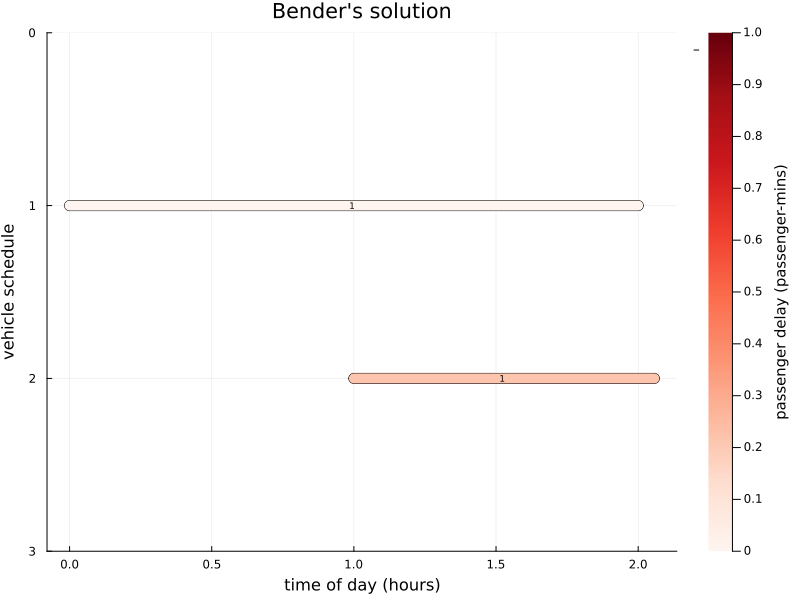

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [105]:
bd_plot_time = plotVSP_time(
    bd_solution.x,
    instance;
    # clims = (0, 6),
    plot_size=(800, 600),
    primary = false,
    endoftrip = true,
    title = "Bender's solution"
)

In [106]:
del_solution.x

5×5 Matrix{Float64}:
 0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0

In [107]:
bd_solution.x

5×5 Matrix{Float64}:
  0.0  -0.0  -0.0  1.0   1.0
 -0.0   0.0  -0.0  0.0  -0.0
 -0.0   0.0   0.0  0.0   0.0
  1.0   0.0   0.0  0.0   0.0
  1.0   0.0   0.0  0.0   0.0

In [88]:
value.(fs.q)

2-element Vector{Float64}:
 10.0
 10.0

In [84]:
f = objective_function(del_model.model)
# this_x = convert(Matrix{Bool}, round.(bd_solution.x))
this_x = convert(Matrix{Bool}, round.(del_solution.x))
n = size(instance.L_train, 1)
numScenarios = size(instance.L_train, 2)
this_s = zeros(Float64, n, numScenarios)
for scenario in 1:numScenarios
    this_s[:, scenario] = feasibleDelays(this_x, instance.L_train[:, scenario], instance.B, endoftrip=true)
end
x = del_model.model[:x]  # Replace `x` with the actual name if it’s different in your model
s = del_model.model[:s]  # Same for `s`
point_x = Dict(x[i,j] => this_x[i, j] for i in 1:n, j in 1:n)
point_s = Dict(s[i,j] => this_s[i+1, j] for i in 1:n-1, j in 1:numScenarios)
point = merge(point_x, point_s)
value(z -> point[z], f)

1370.6666666666665